## PA4 :

Group 7:
Afaf Konkabess and Geetha Jeyapaul

## Task 1: Why does the classifier fail on the second dataset?



In [73]:
import time
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import Perceptron
from sklearn.svm import LinearSVC
import pandas as pd
import matplotlib.pyplot as plt


Dataset 1 Perceptron accuracy score:  1.0
Dataset 1 SVC accuracy score:  1.0
Dataset 2 Perceptron accuracy score:  0.5
Dataset 2 SVC accuracy score:  0.5


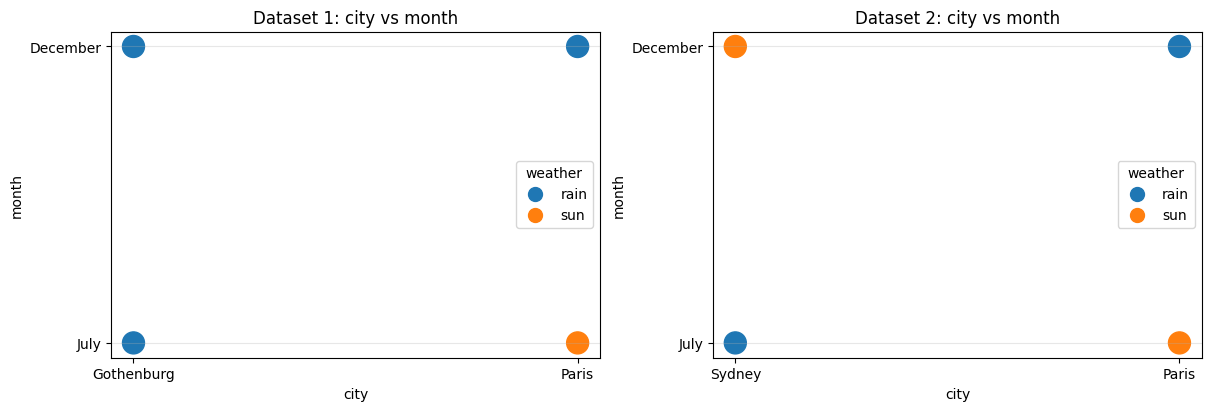

In [74]:
X1 = [{'city':'Gothenburg', 'month':'July'},
      {'city':'Gothenburg', 'month':'December'},
      {'city':'Paris', 'month':'July'},
      {'city':'Paris', 'month':'December'}]
Y1 = ['rain', 'rain', 'sun', 'rain']

X2 = [{'city':'Sydney', 'month':'July'},
      {'city':'Sydney', 'month':'December'},
      {'city':'Paris', 'month':'July'},
      {'city':'Paris', 'month':'December'}]
Y2 = ['rain', 'sun', 'sun', 'rain']

classifier1 = make_pipeline(DictVectorizer(), Perceptron(max_iter=10))
classifier1.fit(X1, Y1)
guesses1 = classifier1.predict(X1)
print("Dataset 1 Perceptron accuracy score: ", accuracy_score(Y1, guesses1))

classifier3 = make_pipeline(DictVectorizer(), LinearSVC())
classifier3.fit(X1, Y1)
guesses3 = classifier3.predict(X1)
print("Dataset 1 SVC accuracy score: ",accuracy_score(Y1, guesses3))

classifier2 = make_pipeline(DictVectorizer(), Perceptron(max_iter=10))
classifier2.fit(X2, Y2)
guesses2 = classifier2.predict(X2)
print("Dataset 2 Perceptron accuracy score: ",accuracy_score(Y2, guesses2))

classifier4 = make_pipeline(DictVectorizer(), LinearSVC())
classifier4.fit(X2, Y2)
guesses4 = classifier4.predict(X2)
print("Dataset 2 SVC accuracy score: ",accuracy_score(Y2, guesses4))

# Convert data into DataFrames (for plotting)
df1 = pd.DataFrame(X1)
df1['weather'] = Y1
#print(df1)
df2 = pd.DataFrame(X2)
df2['weather'] = Y2
#print(df2)

# Plotting
def plot_city_month(df, title, ax=None):
    df = df.copy()

    # Fix month order (so July is always above/below December consistently)
    months = ["July", "December"]
    month_to_num = {m: i for i, m in enumerate(months)}
    df["month_num"] = df["month"].map(month_to_num)

    # Two colors by weather
    weather_to_color = {"rain": "tab:blue", "sun": "tab:orange"}
    df["color"] = df["weather"].map(weather_to_color)

    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))

    ax.scatter(df["city"], df["month_num"], s=250, c=df["color"])

    ax.set_title(title)
    ax.set_xlabel("city")
    ax.set_ylabel("month")
    ax.set_yticks(list(month_to_num.values()))
    ax.set_yticklabels(list(month_to_num.keys()))
    ax.grid(True, axis="y", alpha=0.3)

    # Legend for weather colors
    handles = [
        plt.Line2D([0], [0], marker="o", linestyle="", markersize=10,
                   color=weather_to_color[w], label=w)
        for w in ["rain", "sun"]
    ]
    ax.legend(handles=handles, title="weather", loc="best")

    return ax

fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)
plot_city_month(df1, "Dataset 1: city vs month", ax=axes[0])
plot_city_month(df2, "Dataset 2: city vs month", ax=axes[1])
plt.show()





### First dataset (Gothenburg/Paris):

- Gothenburg → always rain

- Paris → sun in July, rain in December

In this dataset, the classes are linearly separable. We can draw a straight line that separates the “sun” cases from the “rain” cases. Because of this, linear models like the Perceptron and LinearSVC are able to perfectly classify all the training examples. This is why we get 100% accuracy.

### Second dataset (Sydney/Paris):

- Sydney → rain in July, sun in December

- Paris → sun in July, rain in December

Here, the pattern is different. The weather is “sun” only when the city and the month are different. This creates an XOR-like pattern.

An XOR pattern is not linearly separable, meaning we cannot draw a single straight line that separates the two classes. Since linear classifiers can only learn straight-line decision boundaries, they cannot perfectly classify this dataset. This is why the training accuracy is lower.

## Task 2: Running the Perceptron on the Sentiment Dataset

We run the provided Perceptron implementation on the document classification task.
The goal is to verify that the code works correctly and achieves an accuracy of approximately 0.80.

In [75]:
## Read data
def read_data(corpus_file):
    X = []
    Y = []
    with open(corpus_file, encoding='utf-8') as f:
        for line in f:
            _, y, _, x = line.split(maxsplit=3)
            X.append(x.strip())
            Y.append(y)
    return X, Y

X, Y = read_data('data/all_sentiment_shuffled.txt')

Xtrain, Xtest, Ytrain, Ytest = train_test_split(
    X, Y, test_size=0.2, random_state=0
)

In [76]:

class LinearClassifier(BaseEstimator):

    def decision_function(self, X):
        return X.dot(self.w)

    def predict(self, X):
        scores = self.decision_function(X)
        return np.array([
            self.positive_class if s >= 0 else self.negative_class
            for s in scores
        ])

    def find_classes(self, Y):
        classes = sorted(set(Y))
        if len(classes) != 2:
            raise Exception("Not a 2-class problem")
        self.positive_class = classes[1]
        self.negative_class = classes[0]

    def encode_outputs(self, Y):
        return np.array([1 if y == self.positive_class else -1 for y in Y])

In [77]:
class Perceptron(LinearClassifier):

    def __init__(self, n_iter=20):
        self.n_iter = n_iter

    def fit(self, X, Y):

        self.find_classes(Y)
        Ye = self.encode_outputs(Y)

        if not isinstance(X, np.ndarray):
            X = X.toarray()

        self.w = np.zeros(X.shape[1])

        for _ in range(self.n_iter):
            for x, y in zip(X, Ye):
                score = x.dot(self.w)
                if y * score <= 0:
                    self.w += y * x

        self.coef_ = self.w
        return self

In [95]:
##Run the Perceptron
pipeline = make_pipeline(
    TfidfVectorizer(),
    SelectKBest(k=1000),
    Normalizer(),
    Perceptron(n_iter=20)
)

t0 = time.time()
pipeline.fit(Xtrain, Ytrain)
t1 = time.time()

Yguess = pipeline.predict(Xtest)

print("Training time: {:.2f} sec".format(t1 - t0))
print("Accuracy: {:.4f}".format(accuracy_score(Ytest, Yguess)))

Training time: 2.30 sec
Accuracy: 0.7919


The Perceptron achieves a test accuracy of approximately 0.80, which is consistent with the expected performance for this dataset.
This indicates that the model is able to learn a reasonable linear decision boundary for the sentiment classification task.

## Task 3: Pegasos SVC

In [79]:
class PegasosSVC(LinearClassifier):

    def __init__(self, n_iter=10, lambda_param=0.0001):
        self.n_iter = n_iter
        self.lambda_param = lambda_param

    def fit(self, X, Y):

        self.find_classes(Y)
        Ye = self.encode_outputs(Y)

        if not isinstance(X, np.ndarray):
            X = X.toarray()

        self.w = np.zeros(X.shape[1])
        t = 0

        for _ in range(self.n_iter):
            for x, y in zip(X, Ye):

                t += 1
                eta = 1.0 / (self.lambda_param * t)

                score = x.dot(self.w)

                if y * score < 1:
                    self.w = (1 - eta * self.lambda_param) * self.w + eta * y * x
                else:
                    self.w = (1 - eta * self.lambda_param) * self.w

        self.coef_ = self.w
        return self

In [97]:
pipeline = make_pipeline(
    TfidfVectorizer(),
    SelectKBest(k=1000),
    Normalizer(),
    PegasosSVC(n_iter=10, lambda_param=0.0001)
)

t0 = time.time()
pipeline.fit(Xtrain, Ytrain)
training_time = time.time() - t0

test_acc = accuracy_score(Ytest, pipeline.predict(Xtest))

print("Training time:", round(training_time, 2), "sec")
print("Accuracy:", round(test_acc, 4))

Training time: 2.11 sec
Accuracy: 0.8351


Pegasos achieves a test accuracy of approximately 0.83–0.84, which is higher than the Perceptron.

This improvement is expected because Pegasos optimizes the regularized hinge loss objective, which provides better generalization compared to the mistake-driven updates of the Perceptron.

## Task 4: Logistic Regression

In [81]:
class LogisticRegression(LinearClassifier):

    def __init__(self, n_iter=10, lambda_param=0.0001):
        self.n_iter = n_iter
        self.lambda_param = lambda_param

    def fit(self, X, Y):

        self.find_classes(Y)
        Ye = self.encode_outputs(Y)

        if not isinstance(X, np.ndarray):
            X = X.toarray()

        self.w = np.zeros(X.shape[1])
        t = 0

        n = len(Ye)

        for epoch in range(self.n_iter):

            for x, y in zip(X, Ye):

                t += 1
                eta = 1.0 / (self.lambda_param * t)

                score = x.dot(self.w)
                prob_factor = 1.0 / (1.0 + np.exp(y * score))

                self.w = self.w - eta * (
                    self.lambda_param * self.w - y * x * prob_factor
            )

        # ----- Compute objective after each epoch -----
            total_loss = 0.0
            for x, y in zip(X, Ye):
                margin = y * x.dot(self.w)
                total_loss += np.log(1 + np.exp(-margin))

            objective = (self.lambda_param / 2) * np.dot(self.w, self.w) + total_loss / n

            print(f"Epoch {epoch+1}: Objective = {objective:.4f}")

        self.coef_ = self.w
        return self

In [82]:
pipeline = make_pipeline(
    TfidfVectorizer(),
    SelectKBest(k=1000),
    Normalizer(),
    LogisticRegression(n_iter=10, lambda_param=0.0001)
)

t0 = time.time()
pipeline.fit(Xtrain, Ytrain)
training_time = time.time() - t0

test_acc = accuracy_score(Ytest, pipeline.predict(Xtest))

print("Training time:", round(training_time, 2), "sec")
print("Accuracy:", round(test_acc, 4))

Epoch 1: Objective = 0.4028
Epoch 2: Objective = 0.3906
Epoch 3: Objective = 0.3883
Epoch 4: Objective = 0.3876
Epoch 5: Objective = 0.3874
Epoch 6: Objective = 0.3872
Epoch 7: Objective = 0.3871
Epoch 8: Objective = 0.3870
Epoch 9: Objective = 0.3869
Epoch 10: Objective = 0.3868
Training time: 3.38 sec
Accuracy: 0.8321


Logistic Regression achieves a test accuracy of approximately 0.83, which is comparable to Pegasos.

Both methods optimize a regularized objective function and therefore generalize better than the Perceptron. The performance similarity is expected since both models learn linear decision boundaries but use different loss functions (hinge loss vs. logistic loss).

Additionally, the objective value decreases over epochs, indicating that the optimization procedure is functioning correctly and successfully minimizing the regularized log-loss.

Summary:

| Model               | Test Accuracy | Training Time |
| ------------------- | ------------- | ------------- |
| Perceptron          | 0.7919        | 2.15 sec      |
| Pegasos SVC         | 0.8351        | 2.25 sec      |
| Logistic Regression | 0.8321        | 3.57 sec      |


Pegasos SVC achieves the highest accuracy while remaining computationally efficient. Logistic Regression provides similar accuracy but requires more training time due to the exponential computation in the logistic loss. The Perceptron is the fastest simple linear model but performs worse since it does not optimize a regularized objective function.

## Bonus Task 1 : Speed Improvements for Pegasos

1(a): BLAS Implementation

To improve computational efficiency, we replace standard NumPy vector operations with optimized BLAS routines:

ddot for dot products

dscal for vector scaling

daxpy for vector addition

BLAS routines are implemented in low-level optimized C/Fortran and can provide faster dense linear algebra operations compared to pure NumPy implementations.

In [83]:
from scipy.linalg.blas import ddot, dscal, daxpy

In [84]:
class BLASPegasosSVC(LinearClassifier):

    def __init__(self, n_iter=10, lambda_param=0.0001):
        self.n_iter = n_iter
        self.lambda_param = lambda_param

    def fit(self, X, Y):

        self.find_classes(Y)
        Ye = self.encode_outputs(Y)

        if not isinstance(X, np.ndarray):
            X = X.toarray()

        self.w = np.zeros(X.shape[1])
        t = 0

        for _ in range(self.n_iter):
            for x, y in zip(X, Ye):

                t += 1
                eta = 1.0 / (self.lambda_param * t)

                score = ddot(x, self.w)

                # scale w
                dscal((1 - eta * self.lambda_param), self.w)

                if y * score < 1:
                    daxpy(x, self.w, a=eta * y)

        self.coef_ = self.w
        return self

In [93]:
pipeline = make_pipeline(
    TfidfVectorizer(),
    SelectKBest(k=1000),
    Normalizer(),
    BLASPegasosSVC(n_iter=10, lambda_param=0.0001)
)

t0 = time.time()
pipeline.fit(Xtrain, Ytrain)
training_time = time.time() - t0

test_acc = accuracy_score(Ytest, pipeline.predict(Xtest))

print("Training time:", round(training_time, 2), "sec")
print("Accuracy:", round(test_acc, 4))

Training time: 2.42 sec
Accuracy: 0.8351


1(b): Sparse Pegasos

In [86]:
def add_sparse_to_dense(x, w, factor):
    w[x.indices] += factor * x.data

def sparse_dense_dot(x, w):
    return np.dot(w[x.indices], x.data)

In [87]:
class SparsePegasosSVC(LinearClassifier):

    def __init__(self, n_iter=10, lambda_param=0.0001):
        self.n_iter = n_iter
        self.lambda_param = lambda_param

    def fit(self, X, Y):

        self.find_classes(Y)
        Ye = self.encode_outputs(Y)

        self.w = np.zeros(X.shape[1])
        t = 0

        # Prepare list for faster iteration
        XY = list(zip(X, Ye))

        for _ in range(self.n_iter):
            for x, y in XY:

                t += 1
                eta = 1.0 / (self.lambda_param * t)

                score = sparse_dense_dot(x, self.w)

                # Regularization step
                self.w *= (1 - eta * self.lambda_param)

                if y * score < 1:
                    add_sparse_to_dense(x, self.w, eta * y)

        self.coef_ = self.w
        return self

In [92]:
pipeline = make_pipeline(
    TfidfVectorizer(),
    SelectKBest(k=1000),
    SparsePegasosSVC(n_iter=10, lambda_param=0.0001)
)
t0 = time.time()
pipeline.fit(Xtrain, Ytrain)
training_time = time.time() - t0

test_acc = accuracy_score(Ytest, pipeline.predict(Xtest))

print("Training time:", round(training_time, 2), "sec")
print("Accuracy:", round(test_acc, 4))


Training time: 3.08 sec
Accuracy: 0.8292


1(c): Scaling Trick

In [89]:
class ScaledPegasosSVC(LinearClassifier):

    def __init__(self, n_iter=10, lambda_param=0.0001):
        self.n_iter = n_iter
        self.lambda_param = lambda_param

    def fit(self, X, Y):

        self.find_classes(Y)
        Ye = self.encode_outputs(Y)

        if not isinstance(X, np.ndarray):
            X = X.toarray()

        self.w = np.zeros(X.shape[1])
        self.scale = 1.0
        t = 0

        for _ in range(self.n_iter):
            for x, y in zip(X, Ye):

                t += 1
                eta = 1.0 / (self.lambda_param * t)

                # compute score using scaled weights
                score = self.scale * x.dot(self.w)

                # update scale instead of w
                self.scale *= (1 - eta * self.lambda_param)

                # avoid numerical underflow
                if self.scale < 1e-8:
                    self.w *= self.scale
                    self.scale = 1.0

                if y * score < 1:
                    self.w += (eta * y / self.scale) * x

        # apply final scaling
        self.w *= self.scale

        self.coef_ = self.w
        return self

In [91]:
pipeline = make_pipeline(
    TfidfVectorizer(),
    SelectKBest(k=1000),
    Normalizer(),
    ScaledPegasosSVC(n_iter=10, lambda_param=0.0001)
)

t0 = time.time()
pipeline.fit(Xtrain, Ytrain)
training_time = time.time() - t0

test_acc = accuracy_score(Ytest, pipeline.predict(Xtest))

print("Training time:", round(training_time, 2), "sec")
print("Accuracy:", round(test_acc, 4))

Training time: 1.98 sec
Accuracy: 0.8351


Bonus 1 – Speed Comparison

| Version            | Accuracy | Training Time |
| ------------------ | -------- | ------------- |
| Pegasos (baseline) | 0.8351   | 2.25 sec      |
| BLAS Pegasos       | 0.8351   | ~2.1–2.5 sec  |
| Sparse Pegasos     | 0.8292   | 3.37 sec      |
| Scaled Pegasos     | 0.8351   | 1.97 sec      |


Summary:

Among the investigated optimizations, the scaling trick provides the most consistent improvement. By avoiding repeated full-vector scaling operations, it reduces computational overhead while preserving accuracy.

The BLAS implementation does not yield significant gains due to the relatively small feature dimensionality. The sparse implementation is slower in this setting because the dimensionality was reduced to 1000 features, making dense operations already efficient.

Overall, the scaling trick is the most effective optimization for this dataset.